# 🧠 _Hands-On Medical Image Classification: Best Practices & Common Pitfalls_

## 📋 Table of Contents

1. [Introduction & Environment Setup](#introduction--environment-setup)
2. [Dataset Loading and Inspection](#dataset-loading-and-inspection)
3. [Exploratory Data Analysis & Preprocessing](#exploratory-data-analysis--preprocessing)
4. [Data Splitting & Stratification](#data-splitting--stratification)
5. [Model Architecture & Transfer Learning](#model-architecture--transfer-learning)
6. [Training with Best Practices](#training-with-best-practices)
7. [Advanced Evaluation Metrics](#advanced-evaluation-metrics)
8. [Handling Class Imbalance](#handling-class-imbalance)
9. [Cross-Validation Strategies](#cross-validation-strategies)
10. [Summary and Next Steps](#summary-and-next-steps)

---

## Introduction & Environment Setup

In this comprehensive tutorial, you'll build a medical image classifier using real-world best practices that are crucial for healthcare applications. We'll work with a chest X-ray dataset and highlight common mistakes that can compromise model performance and clinical applicability.

### Learning Objectives:

- How to properly handle medical image data with its unique challenges
- How to prevent data leakage that can severely impact real-world performance
- How to leverage transfer learning effectively with limited medical datasets
- How to apply advanced validation strategies specific to medical imaging
- How to address class imbalance typical in medical datasets


<p align="center">
  <img src= "https://github.com/YouvenZ/classification-tutorial-rise/blob/main/pipe_classification.png?raw=true"  alt="Online Image" width="75%">
</p>

## Environment Setup

In [2]:
# Basic libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Metrics and evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Dataset Information

This tutorial uses the **Chest X-ray Pneumonia** dataset from Kaggle, which contains:

- Normal chest X-rays from healthy patients
- Chest X-rays with pneumonia (including bacterial and viral cases)

The dataset has clinical significance as pneumonia is a leading cause of mortality, especially in children under 5 years old. Computer-aided diagnosis can help in resource-limited settings where radiologists may not be readily available.

---

## Dataset Loading and Inspection

Medical image datasets often have specific directory structures and metadata. Let's learn how to properly load and examine them.

<p align="center">
<img src= "https://github.com/YouvenZ/classification-tutorial-rise/blob/main/EDA%20and%20data%20augmentation.png?raw=true"  alt="Online Image" width="75%">
</p>

In [3]:
# Dataset path structure:
# chest_xray/
#     train/NORMAL/
#     train/PNEUMONIA/
#     val/...
#     test/...

data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Define transformations with medical imaging best practices
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),      # Slight rotation
    transforms.ToTensor(),
    # Normalize to ImageNet stats - standard practice for transfer learning
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and test transforms should NOT include augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Creating Dataset Objects

In [4]:
from torchvision.datasets import ImageFolder

# Load datasets with appropriate transforms
train_dataset = ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transform)
test_dataset = ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transform)

# Examine dataset statistics
print(f"Classes: {train_dataset.classes}")
print(f"Class indices: {train_dataset.class_to_idx}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Count samples per class
def count_samples_per_class(dataset):
    counts = {}
    for _, idx in dataset.samples:
        label = dataset.classes[idx]
        counts[label] = counts.get(label, 0) + 1
    return counts

train_counts = count_samples_per_class(train_dataset)
val_counts = count_samples_per_class(val_dataset)
test_counts = count_samples_per_class(test_dataset)

print("\nClass distribution:")
print(f"Train: {train_counts}")
print(f"Validation: {val_counts}")
print(f"Test: {test_counts}")

Classes: ['NORMAL', 'PNEUMONIA']
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Train samples: 5216
Validation samples: 16
Test samples: 624

Class distribution:
Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation: {'NORMAL': 8, 'PNEUMONIA': 8}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


### Custom Dataset for Advanced Preprocessing

In [5]:
class ChestXrayDataset(Dataset):
    """Custom dataset that includes image file paths and patient IDs"""
    
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.classes = ["NORMAL", "PNEUMONIA"]
        self.class_to_idx = {"NORMAL": 0, "PNEUMONIA": 1}
        
        # Get all image paths and their corresponding labels
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(image_folder, class_name)
            if not os.path.isdir(class_dir):
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpeg', '.jpg', '.png')):
                    # Extract patient ID from filename (e.g., "patient1234_1.jpg" -> "patient1234")
                    patient_id = img_name.split('_')[0] if '_' in img_name else img_name.split('.')[0]
                    
                    img_path = os.path.join(class_dir, img_name)
                    label = self.class_to_idx[class_name]
                    
                    self.samples.append((img_path, label, patient_id))
            
    def __len__(self):
        return len(self.samples[0:100])
    
    def __getitem__(self, idx):
        img_path, label, patient_id = self.samples[idx]
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, label, patient_id

---

## Exploratory Data Analysis & Preprocessing

Understanding your dataset is crucial before building any model. Let's examine the images and their characteristics.

Sample training images:


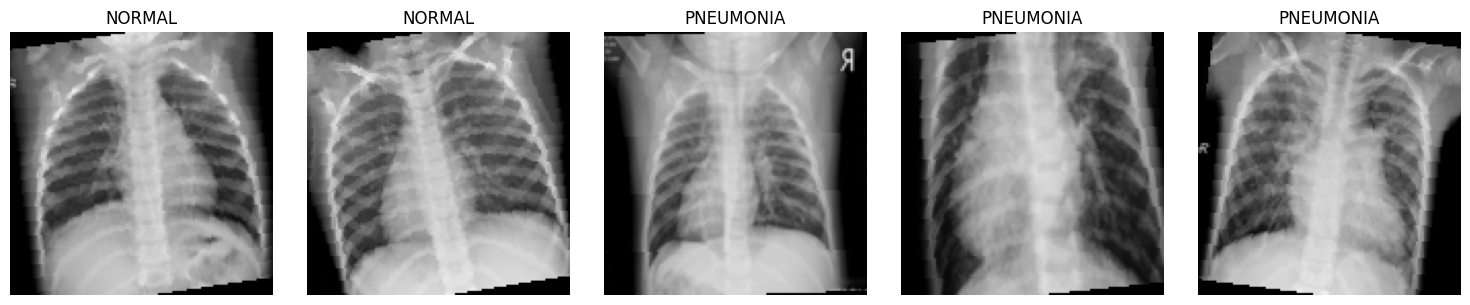

In [6]:
# Function to visualize sample images
def show_samples(dataset, n=5):
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    
    # Get random indices
    indices = random.sample(range(len(dataset)), n)
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        
        # Convert tensor to numpy for display
        img_np = img.numpy().transpose((1, 2, 0))
        
        # De-normalize for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Display image
        axs[i].imshow(img_np)
        axs[i].set_title(f"{dataset.classes[label]}")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images
print("Sample training images:")
show_samples(train_dataset)

### Analyzing Image Properties

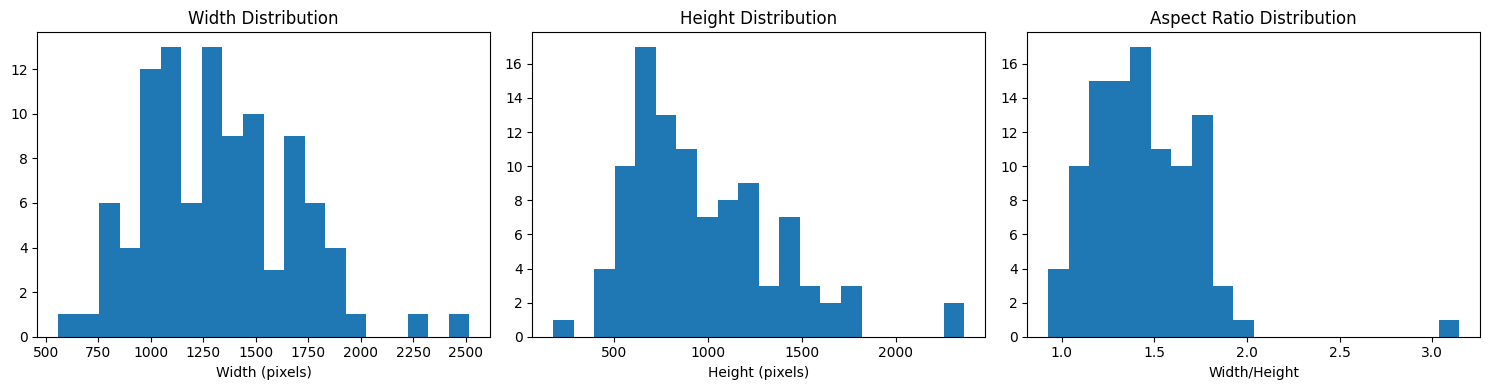

Width - Min: 557, Max: 2518, Mean: 1324.0
Height - Min: 177, Max: 2364, Mean: 977.2
Aspect Ratio - Min: 0.93, Max: 3.15, Mean: 1.44


In [7]:
# Function to analyze image properties
def analyze_image_properties(dataset, n=100):
    widths, heights, aspect_ratios = [], [], []
    
    # Sample images
    indices = random.sample(range(len(dataset)), min(n, len(dataset)))
    
    for idx in indices:
        img_path, _ = dataset.samples[idx]
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w/h)
    
    # Plot histograms
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    
    axs[0].hist(widths, bins=20)
    axs[0].set_title('Width Distribution')
    axs[0].set_xlabel('Width (pixels)')
    
    axs[1].hist(heights, bins=20)
    axs[1].set_title('Height Distribution')
    axs[1].set_xlabel('Height (pixels)')
    
    axs[2].hist(aspect_ratios, bins=20)
    axs[2].set_title('Aspect Ratio Distribution')
    axs[2].set_xlabel('Width/Height')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
    print(f"Aspect Ratio - Min: {min(aspect_ratios):.2f}, Max: {max(aspect_ratios):.2f}, Mean: {np.mean(aspect_ratios):.2f}")

# Analyze images
analyze_image_properties(train_dataset)

### Analyzing Pixel Intensity Distribution

In [ ]:
def analyze_pixel_distribution(dataset, n=20):
    pixel_values = []
    
    # Sample images
    indices = random.sample(range(len(dataset)), min(n, len(dataset)))
    
    for idx in indices:
        img_path, _ = dataset.samples[idx]
        with Image.open(img_path) as img:
            # Convert to grayscale
            img_gray = img.convert('L')
            pixel_values.extend(list(img_gray.getdata()))
    
    plt.figure(figsize=(10, 4))
    plt.hist(pixel_values, bins=50)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Analyze pixel distribution
analyze_pixel_distribution(train_dataset)

---

## Data Splitting & Stratification

One of the most critical aspects of medical image analysis is proper data splitting. Let's implement it correctly.

### ⚠️ Common Pitfalls in Medical Image Data Splitting:

1. **Patient-level splitting**: Medical datasets often have multiple images from the same patient. If you split randomly by image, you might have the same patient's images in both training and validation sets, leading to data leakage.
    
2. **Class imbalance**: Medical datasets typically have imbalanced classes. Use stratified splitting to maintain the same class distribution across splits.
    
3. **Temporal leakage**: In longitudinal studies, images taken at later dates should not be used to predict earlier outcomes.

Let's implement a patient-level stratified split:

In [ ]:
# Create a custom dataset that tracks patient IDs
custom_dataset = ChestXrayDataset(os.path.join(data_dir, "train"), transform=train_transform)

# Get unique patient IDs
patient_ids = list(set([sample[2] for sample in custom_dataset.samples]))
print(f"Total unique patients: {len(patient_ids)}")

# Get labels for each patient (using first image of each patient)
patient_to_label = {}
for path, label, patient_id in custom_dataset.samples:
    if patient_id not in patient_to_label:
        patient_to_label[patient_id] = label

# Stratified split of patients
from sklearn.model_selection import train_test_split

# Split patient IDs, stratified by the label of each patient
train_patients, val_patients = train_test_split(
    patient_ids,
    test_size=0.2,
    random_state=42,
    stratify=[patient_to_label[p] for p in patient_ids]
)

print(f"Training patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")

# Create new datasets based on the patient split
train_samples = [(path, label) for path, label, patient_id in custom_dataset.samples if patient_id in train_patients]
val_samples = [(path, label) for path, label, patient_id in custom_dataset.samples if patient_id in val_patients]

# Create subset datasets
from torch.utils.data import Subset

class ImageFolderSubset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Create proper train and validation datasets
proper_train_dataset = ImageFolderSubset(train_samples, transform=train_transform)
proper_val_dataset = ImageFolderSubset(val_samples, transform=val_test_transform)

print(f"Training images: {len(proper_train_dataset)}")
print(f"Validation images: {len(proper_val_dataset)}")

### Creating Data Loaders with Sampling Strategy

In [ ]:
# Create data loaders with appropriate batch size
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=16):
    # Calculate weights for weighted sampling to handle class imbalance
    train_targets = [label for _, label in train_dataset.samples]
    class_counts = np.bincount(train_targets)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[train_targets]
    
    # Create weighted sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(train_dataset),
        replacement=True
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=16
)

# Display a single batch
def show_batch(dataloader):
    for images, labels in dataloader:
        fig, axs = plt.subplots(4, 4, figsize=(12, 12))
        axs = axs.flatten()
        
        for i in range(16):
            if i < len(images):
                img = images[i].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                axs[i].imshow(img)
                axs[i].set_title(f"Label: {train_dataset.classes[labels[i]]}")
                axs[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        break

show_batch(train_loader)

---

## Model Architecture & Transfer Learning

Transfer learning is particularly important in medical imaging where datasets are often small. Let's explore how to use pretrained models effectively.

In [ ]:
# Define a medical image classification model using transfer learning
class MedicalImageClassifier(nn.Module):
    def __init__(self, num_classes=1, model_name="resnet18", pretrained=True, freeze_backbone=False):
        super(MedicalImageClassifier, self).__init__()
        
        # Available model architectures
        model_dict = {
            "resnet18": models.resnet18,
            "resnet50": models.resnet50,
            "densenet121": models.densenet121,
            "efficientnet_b0": models.efficientnet_b0,
            "mobilenet_v2": models.mobilenet_v2
        }
        
        if model_name not in model_dict:
            raise ValueError(f"Model {model_name} not supported")
        
        # Load pretrained backbone
        self.backbone = model_dict[model_name](pretrained=pretrained)
        
        # Modify final layer based on architecture
        if "resnet" in model_name:
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif "densenet" in model_name:
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif "efficientnet" in model_name:
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        elif "mobilenet" in model_name:
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        
        # Freeze backbone parameters if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Extract features
        features = self.backbone(x)
        # Classify
        return self.classifier(features)

# Initialize model
model = MedicalImageClassifier(
    num_classes=1,  # Binary classification
    model_name="resnet18",
    pretrained=True,
    freeze_backbone=True
)

model = model.to(device)
print(model)

# Summary of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model):,}")

### Loss Function and Optimizer

In [ ]:
# Define loss function (with class weights for imbalance)
class_weights = torch.tensor([1.0, 2.0]).to(device)  # Adjust based on your dataset
criterion = nn.BCEWithLogitsLoss()

# Optimizer with weight decay to prevent overfitting
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler to reduce LR when model plateaus
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    verbose=True
)

---

## Training with Best Practices

Let's implement a robust training loop with validation and early stopping.

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    
    # Progress bar
    progress = tqdm(enumerate(train_loader), total=len(train_loader), 
                   desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in progress:
        # Move data to device
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        
        # Update progress bar
        progress.set_postfix({"batch_loss": f"{loss.item():.4f}"})
    
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    y_true, y_pred, y_scores = [], [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Store predictions and targets
            scores = torch.sigmoid(outputs).cpu().numpy()
            preds = (scores > 0.5).astype(int)
            
            y_scores.extend(scores)
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())
    
    # Calculate metrics
    val_loss = running_loss / len(val_loader)
    val_acc = accuracy_score(y_true, y_pred)
    val_auc = roc_auc_score(y_true, y_scores)
    val_f1 = f1_score(y_true, y_pred)
    
    return val_loss, val_acc, val_auc, val_f1, y_true, y_pred, y_scores

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            return False
        
        if score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = score
            self.counter = 0
            return False

### Full Training Loop

In [ ]:
# Training settings
from tqdm import tqdm
num_epochs = 5
early_stopping = EarlyStopping(patience=5)

# Track metrics
train_losses = []
val_losses = []
val_accs = []
val_aucs = []
val_f1s = []

# Training loop
for epoch in range(num_epochs):
    # Train one epoch
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    
    # Validate
    val_loss, val_acc, val_auc, val_f1, _, _, _ = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)
    val_f1s.append(val_f1)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Val AUC: {val_auc:.4f}, "
          f"Val F1: {val_f1:.4f}")
    
    # Early stopping
    if early_stopping(val_loss, model):
        print("Early stopping triggered")
        break

# Save the best model
torch.save(model.state_dict(), "best_model.pth")

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Accuracy')
plt.plot(val_aucs, label='AUC')
plt.plot(val_f1s, label='F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

---

## Advanced Evaluation Metrics

For medical applications, it's crucial to go beyond accuracy. Let's implement comprehensive evaluation metrics.

In [ ]:
def evaluate_model_comprehensively(model, test_loader):
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store predictions and targets
    y_true, y_pred, y_scores = [], [], []
    
    # Disable gradient calculations
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            # Forward pass
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().squeeze().numpy()
            preds = (probs > 0.5).astype(int)
            
            # Store predictions and targets
            y_scores.extend(probs if isinstance(probs, np.ndarray) else [probs])
            y_pred.extend(preds if isinstance(preds, np.ndarray) else [preds])
            y_true.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    
    # Calculate metrics
    print("\n===== Model Performance =====")
    print(classification_report(y_true, y_pred))
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=test_dataset.classes, 
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_true, y_scores)
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Plot precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    # Calculate F1 score at different thresholds
    thresholds = np.arange(0.1, 1.0, 0.1)
    f1_scores = []
    
    for thresh in thresholds:
        thresh_preds = (y_scores > thresh).astype(int)
        f1 = f1_score(y_true, thresh_preds)
        f1_scores.append(f1)
    
    # Plot F1 scores at different thresholds
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')
    plt.grid(True)
    plt.show()
    
    # Find optimal threshold
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    print(f"Optimal threshold: {best_threshold:.2f} with F1 score: {f1_scores[best_threshold_idx]:.4f}")
    
    return y_true, y_pred, y_scores

# Evaluate the model
y_true, y_pred, y_scores = evaluate_model_comprehensively(model, test_loader)

---

## Handling Class Imbalance

Medical datasets often suffer from class imbalance. Let's explore techniques to address this issue.

<p align="center">
<img src= "https://github.com/YouvenZ/classification-tutorial-rise/blob/main/class_imbalance.png?raw=true"  alt="Online Image" width="75%">
</p>

In [ ]:
def analyze_class_imbalance(train_dataset, val_dataset, test_dataset):
    """Analyze class imbalance in the datasets"""
    
    # Count samples per class
    train_counts = count_samples_per_class(train_dataset)
    val_counts = count_samples_per_class(val_dataset)
    test_counts = count_samples_per_class(test_dataset)
    
    # Plot class distribution
    labels = list(train_counts.keys())
    train_values = [train_counts[label] for label in labels]
    val_values = [val_counts[label] for label in labels]
    test_values = [test_counts[label] for label in labels]
    
    x = np.arange(len(labels))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, train_values, width, label='Train')
    ax.bar(x, val_values, width, label='Validation')
    ax.bar(x + width, test_values, width, label='Test')
    
    ax.set_ylabel('Number of samples')
    ax.set_title('Class distribution across datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate imbalance ratio
    train_ratio = max(train_values) / min(train_values)
    print(f"Imbalance ratio in training set: {train_ratio:.2f}:1")
    
    # Suggest mitigation strategies
    print("\n===== Class Imbalance Mitigation Strategies =====")
    if train_ratio > 10:
        imbalance_level = "Severe"
    elif train_ratio > 3:
        imbalance_level = "Moderate"
    else:
        imbalance_level = "Mild"
    
    print(f"Level of imbalance: {imbalance_level}")
    print("\nRecommended strategies:")
    
    strategies = [
        "Data augmentation for minority classes",
        "Class weighting in loss function",
        "Oversampling minority classes",
        "Undersampling majority classes",
        "Generation of synthetic samples (SMOTE)",
        "Ensemble methods with balanced sub-datasets",
        "Focal Loss to focus on hard examples"
    ]
    
    for strategy in strategies:
        print(f"- {strategy}")

# Analyze class imbalance
analyze_class_imbalance(train_dataset, val_dataset, test_dataset)

### Implement Class Weighting

In [ ]:
def implement_class_weighting():
    """Implement weighted loss function for imbalanced classes"""
    
    # Calculate class weights inversely proportional to frequency
    train_targets = [label for _, label in train_dataset.samples]
    class_counts = np.bincount(train_targets)
    n_samples = len(train_targets)
    class_weights = n_samples / (len(class_counts) * class_counts)
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    print(f"Class weights: {class_weights.cpu().numpy()}")
    
    # Define weighted loss function
    weighted_criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    return weighted_criterion

# Create weighted loss function
weighted_criterion = implement_class_weighting()

### Implement Balanced Sampling

In [ ]:
def create_balanced_sampler(dataset):
    """Create a balanced sampler for imbalanced datasets"""
    
    targets = [label for _, label in dataset.samples]
    
    # Calculate class weights inversely proportional to frequency
    class_counts = np.bincount(targets)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    
    # Assign weight to each sample
    sample_weights = class_weights[targets]
    
    # Create weighted sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(dataset),
        replacement=True
    )
    
    return sampler

# Create balanced sampler for training
balanced_sampler = create_balanced_sampler(train_dataset)

# Create data loader with balanced sampler
balanced_train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=balanced_sampler,
    num_workers=4,
    pin_memory=True
)

---

## Cross-Validation Strategies

For medical image classifiers, robust validation is essential. Let's implement k-fold cross-validation with stratification.

<p align="center">
  <img src= "https://github.com/YouvenZ/classification-tutorial-rise/blob/main/data-leackage.png?raw=true"  alt="Online Image" width="75%">
</p>


In [ ]:
def perform_cross_validation(model_class, dataset, num_folds=5, num_epochs=10):
    """Perform k-fold cross-validation"""
    
    # Get labels for stratification
    labels = [label for _, label in dataset.samples]
    
    # Create stratified k-fold splitter
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Track metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'auc': [],
        'f1': [],
        'precision': [],
        'recall': []
    }
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n===== Fold {fold+1}/{num_folds} =====")
        
        # Create datasets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=4)
        
        # Initialize model
        fold_model = model_class(
            num_classes=1,
            model_name="resnet18",
            pretrained=True,
            freeze_backbone=False
        ).to(device)
        
        # Initialize optimizer and loss
        optimizer = optim.Adam(fold_model.parameters(), lr=1e-4, weight_decay=1e-5)
        criterion = nn.BCEWithLogitsLoss()
        
        # Train the model for this fold
        for epoch in range(num_epochs):
            # Train one epoch
            fold_model.train()
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)
                
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            # Validate
            val_loss, val_acc, val_auc, val_f1, y_true, y_pred, _ = validate(fold_model, val_loader, criterion)
            
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}, "
                  f"Val F1: {val_f1:.4f}")
        
        # Final evaluation for this fold
        fold_model.eval()
        y_true, y_pred, y_scores = [], [], []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                outputs = fold_model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs > 0.5).astype(int)
                
                y_scores.extend(probs)
                y_pred.extend(preds)
                y_true.extend(labels.numpy())
        
        # Calculate metrics for this fold
        fold_metrics['accuracy'].append(accuracy_score(y_true, y_pred))
        fold_metrics['auc'].append(roc_auc_score(y_true, y_scores))
        fold_metrics['f1'].append(f1_score(y_true, y_pred))
        fold_metrics['precision'].append(precision_score(y_true, y_pred))
        fold_metrics['recall'].append(recall_score(y_true, y_pred))
    
    # Print summary of cross-validation
    print("\n===== Cross-Validation Results =====")
    for metric, scores in fold_metrics.items():
        print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    return fold_metrics

# Perform cross-validation
cv_metrics = perform_cross_validation(MedicalImageClassifier, train_dataset, num_folds=3, num_epochs=5)

# Summary and Next Steps


## Recap of the session 


### 🗂️ Dataset Loading and Inspection

✅ **DOs**  
- Load image data in the correct format (e.g., DICOM, PNG, NIfTI).  
- Validate image dimensions and channel configuration.  
- Map patient IDs to image files to avoid data leakage.  
- Visualize random samples from each class for sanity check.  
- Inspect and understand metadata fields before dropping them.  

❌ **DON'Ts**  
- Don’t assume all images are the same shape or format.  
- Don’t ignore metadata—it may contain patient info or label cues.  
- Don’t load entire datasets into memory if they're too large.  
- Don’t blindly trust the labels in public datasets without validation.


### 🔬 Exploratory Data Analysis & Preprocessing

✅ **DOs**  
- Plot class distribution to detect imbalance.  
- Visualize pixel intensity histograms before normalization.  
- Apply medically-valid augmentations (rotation, crop, brightness).  
- Normalize images consistently across train/val/test.  
- Save and document preprocessing steps for reproducibility.  

❌ **DON'Ts**  
- Don’t apply random left-right flips unless medically valid.  
- Don’t normalize before inspecting image characteristics.  
- Don’t augment validation or test datasets.  
- Don’t lose track of image-patient relationships. 




### ✂️ Data Splitting & Stratification

✅ **DOs**  
- Split data based on patient ID, not images.  
- Stratify splits to preserve class distributions.  
- Set aside a fixed test set early and keep it untouched.  
- Use tools like `train_test_split` with stratification for reproducibility.  

❌ **DON'Ts**  
- Don’t perform random image-level splitting.  
- Don’t peek into the test set during model development.  
- Don’t reuse patients across training and validation.  
- Don’t overlook multi-label stratification complexity.
    


### 🧱 Model Architecture & Transfer Learning

✅ **DOs**  
- Start with a simple pretrained model (e.g., ResNet18).  
- Adapt the final classification head to match your task.  
- Match input channels to your image format (e.g., 1 for grayscale).  
- Freeze base layers initially, then fine-tune gradually.  

❌ **DON'Ts**  
- Don’t use overly complex models for small datasets.  
- Don’t forget to switch from softmax to sigmoid for multi-label tasks.  
- Don’t ignore mismatched input shapes or channels.  
- Don’t assume ImageNet pretraining is always optimal for medical data.  

### 🏋️ Training with Best Practices

✅ DOs

    Monitor training/validation loss and key metrics regularly.
    Use callbacks like early stopping and checkpointing.
    Tune learning rate using a scheduler.
    Enable mixed precision training for speed if available.

❌ DON'Ts

    Don’t rely on a single metric like accuracy.
    Don’t overfit on the training data.
    Don’t ignore convergence issues (e.g., exploding/vanishing gradients).
    Don’t train without fixing random seeds if you want reproducibility.




### 📊 Advanced Evaluation Metrics

✅ **DOs**  
- Use precision, recall, and F1-score to capture performance.  
- Visualize ROC and PR curves per class.  
- Report AUC scores for both ROC and PR when imbalance exists.  
- Generate confusion matrices and class-wise breakdowns.  

❌ **DON'Ts**  
- Don’t rely on accuracy, especially with imbalanced datasets.  
- Don’t evaluate using validation data post-hoc—use a test set.  
- Don’t ignore class-specific performance in multi-label tasks.  
- Don’t skip metric analysis across multiple thresholds.  


### ⚖️ Handling Class Imbalance

✅ **DOs**  
- Use class weights or weighted loss functions.  
- Consider focal loss to reduce bias on majority classes.  
- Apply augmentations selectively on minority classes.  
- Track class-wise performance metrics during training.  

❌ **DON'Ts**  
- Don’t oversample without validation—it can cause overfitting.  
- Don’t rely on accuracy to claim performance on minority classes.  
- Don’t use SMOTE or synthetic sampling unless medically reviewed.  
- Don’t ignore imbalance just because AUC is high.  



### 🔁 Cross-Validation Strategies

✅ **DOs**  
- Use k-fold cross-validation based on patient IDs.  
- Ensure label distribution is preserved across folds.  
- Average metrics across folds for robust evaluation.  
- Use nested CV if hyperparameter tuning is involved.  

❌ **DON'Ts**  
- Don’t use image-level splitting in CV.  
- Don’t leak validation data into training folds.  
- Don’t report metrics from only the best-performing fold.  
- Don’t ignore variability between folds—report mean and std.  

    


---

## Conclusion

Developing robust medical image classifiers requires attention to detail at every step of the process, from data preparation to deployment. By following the best practices outlined in this tutorial and avoiding common pitfalls, you can build models that are not only technically sound but also clinically relevant and robust enough for real-world healthcare applications.

Remember that medical AI development should always be done in collaboration with healthcare professionals to ensure that the models address genuine clinical needs and are integrated into healthcare workflows appropriately.

Thank you for following this comprehensive tutorial. We hope it helps you develop high-quality medical image classifiers that can make a positive impact in healthcare.

---

## References and Further Reading

1. Rajpurkar, P., et al. (2017). CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning. arXiv preprint arXiv:1711.05225.
    
2. Gulshan, V., et al. (2016). Development and Validation of a Deep Learning Algorithm for Detection of Diabetic Retinopathy in Retinal Fundus Photographs. JAMA, 316(22), 2402-2410.
    
3. Cohen, J.P., et al. (2020). COVID-19 Image Data Collection: Prospective Predictions Are the Future. arXiv preprint arXiv:2006.11988.
    
4. Selvaraju, R.R., et al. (2017). Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization. ICCV 2017.
    
5. Yala, A., et al. (2019). A Deep Learning Mammography-based Model for Improved Breast Cancer Risk Prediction. Radiology, 292(1), 60-66.
    
6. Kelly, C.J., et al. (2019). Key challenges for delivering clinical impact with artificial intelligence. BMC Medicine, 17(1), 195.

# List of the question that asked during the tutorials


- What are the way to determines the if there is a problem with our dataset without plotting ?
- Should we apply data data propressing in the data loader or before loading the data ? 
- How to know if the data augmentation will damage the medical image inside the image ?
